# Surplus Study  - Surplus/LVR Historic COW  

**The purpose of this study is to measure the surplus for historic COW trades of a desired token pair.** 


**Definitions:**  
$X$ = reserves of token1  
$Y$ = reserves of token2  
$dx$ = trade quantity of token1 for a given trade  (Given by historic COW trade)  
$dy$ = trade quantity of token2 for a given trade (Given by historic COW trade)   
$dy_f$ = The calculated Feedlot price for a given dx     
$dx_f$ = The calculated Feedlot price for a given dy  
$Pfeedlot$ = internal price calculated based on reserves and cpmm formula for a given trade given by $dx_f / dy$  
$Pmarket$ = the COW trade execution price. Could also be called the $Pucp$ It is given by $dx / dy$

**Surplus Calculations:** 

Surplus is defined by $(Pfeedlot - Pmarket) * quantity$ 

There are two variables related to surplus used in the code: surplus_price and surplus_volume defined as:


- Surplus_price:
    - $Pfeedlot = dx_f / dy$ (or $dx/dy_f$ depending on which one is the sell token (input to pricing function)) 
    - $Pmarket = dx / dy$
    - $Surplusprice = Pfeedlot - Pmarket$
      
- Surplus_volume: 
    - $Surplusvolume = Surplusprice * dy$  
    
    
Convention: Define Surplus volume in terms of token1 (token x). Hence multiplying by $dy$ obtains surplus in terms of token $x$ (token1)




**Methodology:** 
- Assume a Feedlot AMM with CPMM preferences that only trades COW orders. Given by $XY = K$  
    where:  
        $X$ = reserves of token1   
        $Y$ = reserves of token2  
        $K = X * Y$  
        
- Feedlot AMM trades at the COW settelement price (which is the solver price) if the trade offers satisfies the preferences (k_new > k_current) and retains any difference (surplus) 
          
- Given a dataset that represents the list of all trades that happened on COW Swap with value over USD 250 with first trade at timestamp $t_0$. 
- Model Inputs: 
    - `token1`: Token1 of token pair to be studied 
    - `Token2`: Token2 of token pair to be studied 
    - `token1_starting_reserves`: Starting reserves of the feedlot AMM pool. 
    - `fee_rate`: Fee rate charged to the trade 
  
- Initialize a feedlot AMM for token1 and token2, at $t_0$ with the price of the first trade at t0 of the COW dataset of token1 and token2, using the starting reserves given by the input (calculating token1_starting_reserves * price at $t_0$) 

- Loop through all trades and check at each trade if $Pfeedlot$ < $Pucp$. (in code it is given by `k_new > k`). If the price of feedlot was favourable then trade is executed on Feedlot AMM and new reserves are updated. 

### 1. Loading COW Dataset 

Copy the dataset file into the folder that contains this notebook. 

In [1]:
from datastreams.datastream import Streamer

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
# instantiate Streamer class. Note that we need two separate streamer classes, otherwise the queries will be overwritten. 
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

In [3]:
# DEFINE TIMESTAMP HERE. Minimum Timstamp is used for replication quality assurance purposes. Timestamp date: 
timestamp =  1646092800

# we set a fixed query size number. The Cow settlements and Uniswap swaps query are multiples larger than this initial query size.
query_size = 500000

#Filter size - We filter trades out that are smaller than $1000 USD size
filter_usd = 100

In [4]:
# query COW schema: trades
trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades. Query on query_size. 
trades_qp = trades_fp(
    first=query_size,
    orderBy='timestamp',
    orderDirection='desc',
    where = {
    'timestamp_gt': timestamp
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

FIELD - trades


In [385]:
print(f'query returned {len(trades_df)} rows')

query returned 331802 rows


In [386]:
trades_df.to_csv('trades_df.csv')

In [387]:
trades_df.head(5)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint
0,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,57740371011993296896,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,5960372533464009646,75000400000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0,5.9604,0.0000,9638.6062,0.0000,cow
1,0x9fb2365e569b1c0d5a67ee6df4d2cfedcbd27e8428c85b9a689f7c9c827d81d85ac0210e0d6d03cbdf85511474f5f714d25ee183640ef9c2|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,4110177118564564992,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,22062282427,6331735533211306433308,0xc0c293ce456ff0ed870add98a0828dd4d2903dbf,0xdac17f958d2ee523a2206206994597c13d831ec7,0x9fb2365e569b1c0d5a67ee6df4d2cfedcbd27e8428c85b9a689f7c9c827d81d85ac0210e0d6d03cbdf85511474f5f714d25ee183640ef9c2,13.6430,13.9606,22062.2824,22586.8324,cow
2,0x01677bcd2d56006fba89e82dc5d636000a33063e77740ab9726d39938642b980ecbaf5c200b290caa0ce63a098a34808ea8c46f7640ef97b|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,1589781568748924,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,8439662236627212,10034390284677249,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x01677bcd2d56006fba89e82dc5d636000a33063e77740ab9726d39938642b980ecbaf5c200b290caa0ce63a098a34808ea8c46f7640ef97b,0.0084,0.0100,13.6479,16.0041,cow
3,0xc39619df51e440d4deac17956afe5b18dec61d7b2b1f7bce28ebb1956314fb129fa6c303300ed23cefb0b1106ae898810dc01cc3640ee92e|0x6e872ab8fab8d5d7a5ba6314d09a3e58a1af2098f5c5d7337b5b3ffc0b3f1eed|46,1678697075,18059272064,3883604,0x6e872ab8fab8d5d7a5ba6314d09a3e58a1af2098f5c5d7337b5b3ffc0b3f1eed,0x6e872ab8fab8d5d7a5ba6314d09a3e58a1af2098f5c5d7337b5b3ffc0b3f1eed,427576131123171816474,1195800000,0xdac17f958d2ee523a2206206994597c13d831ec7,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,0xc39619df51e440d4deac17956afe5b18dec61d7b2b1f7bce28ebb1956314fb129fa6c303300ed23cefb0b1106ae898810dc01cc3640ee92e,0.7413,0.7391,1208.2066,1195.8000,cow
4,0x13ad7e69413a0ac1c909fa302cd28716b56dfbbaff1737d9fa511a2d9034b1504179284c327b35ef08016f9112b8a4867207e79a640ee908|0x48f48d92be321b0f9d92c866c3e4517b59483dd9fae9368bb373dd5946281fdd|103,1678697039,15685415532,15747396302561077248,0x48f48d92be321b0f9d92c866c3e4517b59483dd9fae9368bb373dd5946281fdd,0x48f48d92be321b0f9d92c866c3e4517b59483dd9fae9368bb373dd5946281fdd,243839109141077509,2326905897847167316748,0xe60779cc1b2c1d0580611c526a8df0e3f870ec48,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x13ad7e69413a0ac1c909fa302cd28716b56dfbbaff1737d9fa511a2d9034b1504179284c327b35ef08016f9112b8a4867207e79a640ee908,0.2438,0.0000,394.5055,0.0000,cow


In [388]:
# Set query size large enough to retrieve all tokens in the graph
query_size_token = 10000000

token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=query_size_token,
)

# run query
token_df = cow_ds.runQuery(token_qp)

FIELD - tokens


In [389]:
# Merge1 on sell token address.  x = sell token 

merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

In [390]:
# Merge2 on buy token address.  y = buy token 
merged_df2 = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

In [391]:
df = merged_df2.rename(columns={
    "tokens_symbol_x": "sell_token_symbol",
    "tokens_symbol_y":"buy_token_symbol",
    "tokens_decimals_x": "sell_token_decimal", 
    "tokens_decimals_y": "buy_token_decimal"})

In [392]:
df.head(5)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint_x,tokens_id_x,tokens_address_x,tokens_firstTradeTimestamp_x,tokens_name_x,sell_token_symbol,sell_token_decimal,tokens_totalVolume_x,tokens_priceEth_x,tokens_priceUsd_x,tokens_numberOfTrades_x,tokens_totalVolumeUsd_x,tokens_totalVolumeEth_x,endpoint_y,tokens_id_y,tokens_address_y,tokens_firstTradeTimestamp_y,tokens_name_y,buy_token_symbol,buy_token_decimal,tokens_totalVolume_y,tokens_priceEth_y,tokens_priceUsd_y,tokens_numberOfTrades_y,tokens_totalVolumeUsd_y,tokens_totalVolumeEth_y,endpoint
0,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,57740371011993296896,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,5960372533464009646,75000400000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0,5.9604,0.0000,9638.6062,0.0000,cow,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xfd0205066521550d7d7ab19da8f72bb004b4c341,1673609795,Liquidity Incentive Token,LIT,18,204145645452965008648253746,0.0000,0.0000,2289,34695.6825,21.4961,cow,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,1628150700,,,18,1525234419881098066553457,1.0000,1691.4162,133544,2944412771.6702,1525234.4199,cow
1,0xb4a7499f89e945dc83f203c534b5d778489e41fe4b083987f2334a5f8a585dce8cd6f461662451688e8cfc3cfdeeac55bc3b8648640ec917|0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4|77,1678684619,15570611508,25586676311281516544,0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4,0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4,120000000000000000,1511201804103806248025,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xb4a7499f89e945dc83f203c534b5d778489e41fe4b083987f2334a5f8a585dce8cd6f461662451688e8cfc3cfdeeac55bc3b8648640ec917,0.1200,0.0000,193.6748,0.0000,cow,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xfd0205066521550d7d7ab19da8f72bb004b4c341,1673609795,Liquidity Incentive Token,LIT,18,204145645452965008648253746,0.0000,0.0000,2289,34695.6825,21.4961,cow,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,1628150700,,,18,1525234419881098066553457,1.0000,1691.4162,133544,2944412771.6702,1525234.4199,cow
2,0x7cfd93136f35bb5324a2be2a99e56746f2f3e2b751d02fd09117a8da00f594524098503de63ca5c0686c1cc952138f928b7b9aab640e7cc7|0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58|212,1678665083,41018039430,117280370428390195200,0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58,0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58,224290500967350164,3000000000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x7cfd93136f35bb5324a2be2a99e56746f2f3e2b751d02fd09117a8da00f594524098503de63ca5c0686c1cc952138f928b7b9aab640e7cc7,0.2243,0.0000,358.3995,0.0000,cow,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xfd0205066521550d7d7ab19da8f72bb004b4c341,1673609795,Liquidity Incentive Token,LIT,18,204145645452965008648253746,0.0000,0.0000,2289,34695.6825,21.4961,cow,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,1628150700,,,18,1525234419881098066553457,1.0000,1691.4162,133544,2944412771.6702,1525234.4199,cow
3,0x72f1b9e2b5cfb380b6f1d4978db33a0938f3261e8e4c155f3ec8ca05fbcd1bdc0e242b564e89ff2cc2d3c25354bb923feb5c1e0d640e4aae|0x320f21701f23073cc3e0f

In [393]:
df.shape

(331802, 42)

In [394]:
df.dtypes

trades_id                        object
trades_timestamp                  int64
trades_gasPrice                   int64
trades_feeAmount                 object
trades_txHash                    object
trades_settlement_id             object
trades_buyAmount                 object
trades_sellAmount                object
trades_sellToken_id              object
trades_buyToken_id               object
trades_order_id                  object
trades_buyAmountEth             float64
trades_sellAmountEth            float64
trades_buyAmountUsd             float64
trades_sellAmountUsd            float64
endpoint_x                       object
tokens_id_x                      object
tokens_address_x                 object
tokens_firstTradeTimestamp_x      int64
tokens_name_x                    object
sell_token_symbol                object
sell_token_decimal                int64
tokens_totalVolume_x             object
tokens_priceEth_x               float64
tokens_priceUsd_x               float64


In [395]:
df = df[[
    'trades_id',                        
    'trades_timestamp',                  
    'trades_gasPrice',                   
    'trades_feeAmount',                 
    'trades_txHash',                    
    'trades_buyAmount',                 
    'trades_sellAmount',                
    'trades_sellToken_id',              
    'trades_buyToken_id',               
    'trades_buyAmountUsd',             
    'trades_sellAmountUsd',            
    'sell_token_symbol',                
    'sell_token_decimal',                
    'buy_token_symbol',                 
    'buy_token_decimal'                 
    
]]

In [396]:
df.head(3)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_buyAmountUsd,trades_sellAmountUsd,sell_token_symbol,sell_token_decimal,buy_token_symbol,buy_token_decimal
0,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,57740371011993296896,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,5960372533464009646,75000400000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,9638.6062,0.0000,LIT,18,,18
1,0xb4a7499f89e945dc83f203c534b5d778489e41fe4b083987f2334a5f8a585dce8cd6f461662451688e8cfc3cfdeeac55bc3b8648640ec917|0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4|77,1678684619,15570611508,25586676311281516544,0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4,120000000000000000,1511201804103806248025,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,193.6748,0.0000,LIT,18,,18
2,0x7cfd93136f35bb5324a2be2a99e56746f2f3e2b751d02fd09117a8da00f594524098503de63ca5c0686c1cc952138f928b7b9aab640e7cc7|0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58|212,1678665083,41018039430,117280370428390195200,0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58,224290500967350164,3000000000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,358.3995,0.0000,LIT,18,,18


In [397]:
# calculate buy and sell amounts from the correct decimal 
df['buy_amount'] = df.apply(lambda x: x['trades_buyAmount'] / (10**x['buy_token_decimal']), axis=1)
df['sell_amount'] = df.apply(lambda x: x['trades_sellAmount'] / (10**x['sell_token_decimal']), axis=1)

In [398]:
# Add new empty columns needed for analysis & specify their data types 
df['cow_price'] = 0.0                  
df['pool_price'] = 0.0  # The CFMM price for a given trade. Given trade is the sell_token and its amount. 
df['surplus_volume'] = 0.0            
df['surplus_price'] = 0.0          
df['surplus_percent'] = 0.0        
df['executed'] = False     
df['k']=0.0  #23
df['k_new']=0.0 #24

df['cow_price'] = df['cow_price'].astype(float)
df['pool_price'] = df['pool_price'].astype(float)
df['surplus_volume'] = df['surplus_volume'].astype(float)
df['surplus_price'] = df['surplus_price'].astype(float)
df['surplus_percent'] = df['surplus_percent'].astype(float)
df['executed'] = df['executed'].astype(bool)
df['k'] = df['k'].astype(float)
df['k_new'] =df['k_new'].astype(float) 

In [399]:
df.dtypes

trades_id                object
trades_timestamp          int64
trades_gasPrice           int64
trades_feeAmount         object
trades_txHash            object
trades_buyAmount         object
trades_sellAmount        object
trades_sellToken_id      object
trades_buyToken_id       object
trades_buyAmountUsd     float64
trades_sellAmountUsd    float64
sell_token_symbol        object
sell_token_decimal        int64
buy_token_symbol         object
buy_token_decimal         int64
buy_amount              float64
sell_amount             float64
cow_price               float64
pool_price              float64
surplus_volume          float64
surplus_price           float64
surplus_percent         float64
executed                   bool
k                       float64
k_new                   float64
dtype: object

## 2. Surplus Calculation Function 

Detailed steps of the function: 

1. Filter the dataset for token1 and token2 trades only
2. Calculate price for each trade based on whether token1 was the buy or token2. Price defined as Token1/Token2. 
3. Use the price of the first trade to initialize the feedlot AMM pool with token1_starting_reserves
3. Loop through trades and check if `k_new > k` and if yes, execute trade by reflecting new reserves level 

Note about fees calculation:
For the purpose of this study we wish to study the actual historic trades without altering the actual quantities traded by the traders, as this reflects the true prices the traders were willing to accept trading at. This means the dx and dy values do not change in the simulation and are kept as is from the COW trades dataset. This means in the presence of fees in our model, it is assumed that there happens to be a value dx' which if applied fees to results in the dx given in the dataset: So $dx' * (1+s)=dx$ 

So in order to arrive at dx we want, we did $dx/(1+s)$ to estimate the trades that would have executed with a fee to simulate that in the presence of higher and higher fees it would reflect in worse pricing for the user.   


Note: To avoid confusion, the definitions of dx and dy at start of notebook refer to token1 and token2, in this loop, dx and dy are just used for calculation purposes. Hence, sometimes dx is token1, somtimes its token2. 

In [348]:
from datetime import datetime
 

def surplus_analysis(token1:str, token2:str, token1_starting_reserves:int, fee_rate:float):
    
    """
    Perform surplus analysis for specific trading pair given by token1 and token2. 

    This function filters the required tokens for the simulation, initializes a feedlot AMM (CPMM) with starting 
    price corresponding to first trade in the list and a given initial reserves, loops through trade by trade and 
    checks if P_feedlot < Pmarket. If yes (k_new > k_current), it executes the trade in Feedlot using the standard 
    CPMM formula. 

    Parameters:
        token1 (str): The first token to perform the surplus analysis on.
        token2 (str): The second token to perform the surplus analysis on.
        starting_reserves (int): The starting reserves of token1. 
        fee_rate (float): The fee rate for the transactions.

    Returns:
        trades_executed_percentage : Percentage of trades executed on Feedlot AMM that met the condition P_feedlot < Pmarket
        executed_volume_percentage : volume of executed trades as percentage of total volume of swaps for token1 and token2
        total_surplus: Sum of surplus in USD terms 
    
    """
    
    
    # Filter the required tokens for the simulation 
   
    dfs = df[((df.buy_token_symbol == token1) & (df.sell_token_symbol == token2)) | ((df.sell_token_symbol == token1) & (df.buy_token_symbol == token2))]
    dfs.sort_values(by='trades_timestamp', ascending=True, inplace=True)
    dfs = dfs[dfs['trades_sellAmountUsd'] > 250]
    dfs = dfs.reset_index(drop=True)
    dfs.to_csv('raw_trades_dataset.csv', index=False)
    
    print('dfs', len(dfs), 'trades in sample')


    # Calculate price column. Only important for analysis is first price to initialize pool with it. 
    # Check if its a buy or a sell and calculate accordingly. 
    for i in range(len(dfs)):
        if dfs.loc[i,'sell_token_symbol'] == token1:
            dfs.loc[i,'cow_price'] = dfs.loc[i,'sell_amount'] / dfs.loc[i,'buy_amount']  

        if dfs.loc[i,'sell_token_symbol'] == token2:
            dfs.loc[i,'cow_price'] = dfs.loc[i,'buy_amount'] / dfs.loc[i,'sell_amount']     
    dfs = dfs[dfs['cow_price'] != 0]
    
    print('price column added')
    
    
    # initialize AMM pool 
    s = fee_rate 
    initialization_price = dfs.loc[dfs.index[0],'cow_price']  
    token2_starting_reserves = token1_starting_reserves / initialization_price
    x = token1_starting_reserves 
    y = token2_starting_reserves 
    k = x * y 
    k_new = k 
    
    print('****** Feedlot AMM Initial State **********')
    print('''AMM Initialized with the following parameters:
    initilization price = {}
    x= {}
    y= {}
    k= {}
    s= {}'''.format(initialization_price, token1_starting_reserves, token2_starting_reserves, k, s))


    # Iterating through trades and checking if the trade would have been executed through Feedlot AMM
    # The condition is k_new > k  
    # Variables to monitor (trades: total trades executed, fees: total fees collected, volume : total volume executed) 

    trades  = 0 
    fees_collected = 0 
    volume = 0 
    
    for i in range(len(dfs)):
        
        # noting the k row to row for reference and visibility
        dfs.loc[i,'k'] = k

        # if token_1 is the "buy token"
        if dfs.loc[i,'buy_token_symbol'] == token1:
            dx = dfs.loc[i,'buy_amount']
            dy = dfs.loc[i,'sell_amount']
            k_new = (x - dx) * (y + (dy/(1+s))) 
            # note the calculated value in the table for reference
            dfs.loc[i,'k_new'] = k_new
            # if token1 is the buy token, then token2 is the sell token which is dy. So given dy what is dx_f? 
            dx_f = x - (k / (y + (dy/(1+s))))
            p_feedlot = dx_f / dy
            dfs.loc[i,'pool_price'] = p_feedlot
            
            if k_new > k:
                surplus_price = abs(p_feedlot - dfs.loc[i,'cow_price'])
                dfs.loc[i,'surplus_volume'] =  surplus_price * dy  # surplus in token1 terms
                dfs.loc[i,'surplus_price'] = surplus_price
                dfs.loc[i,'surplus_percent'] = surplus_price / dfs.iloc[i,6] * 100 # surplus as % of trade volume
                dfs.loc[i,'executed'] = 1 # trade executed signal 
                volume = volume + dfs.loc[i,'trades_sellAmountUsd']
                fees_collected = fees_collected + (s * dfs.loc[i,'trades_sellAmountUsd']) 
                trades = trades + 1 
                k = k_new 
                x = x - dx
                y = y + dy/(1+s)

        # if token_2 is the "buy token"
        elif dfs.loc[i,'buy_token_symbol'] == token2:
            dx = dfs.loc[i,'sell_amount'] 
            dy = dfs.loc[i,'buy_amount']
            k_new = (x + (dx/(1+s))) * (y - dy) 
            dfs.loc[i,'k_new'] = k_new
            # if token2 is the buy token, then token1 is the sell token which is dx. So given dx what is dy? 
            dy_f = y - (k / (x + (dx/(1+s))))
            p_feedlot = dx / dy_f
            dfs.loc[i,'pool_price'] = p_feedlot

            if k_new > k: 
                surplus_price = abs(p_feedlot - dfs.loc[i,'cow_price'])
                dfs.loc[i,'surplus_volume'] =  surplus_price * dy  # surplus in token1 terms 
                dfs.loc[i,'surplus_price'] = surplus_price
                dfs.loc[i,'surplus_percent'] = surplus_price / dfs.iloc[i,6] * 100 # surplus as % of trade volume
                dfs.loc[i,'executed'] = 1 # trade executed signal 
                volume = volume + dfs.loc[i,'trades_sellAmountUsd']
                fees_collected = fees_collected + (s * dfs.loc[i,'trades_sellAmountUsd']) 
                trades = trades + 1 
                k = k_new 
                x = x + (dx/(1+s))
                y = y - dy

    dfs.to_csv('results_similation.csv', index=False)

    # Analysis results 
    
    total_trades = len(dfs)
    
    # use the sell amount USD provided in subgraph as an estimate for total trade volume
    total_volume = dfs['trades_sellAmountUsd'].sum()
    total_surplus = dfs['surplus_volume'].sum() 

    trades_executed_percentage = trades / total_trades * 100 
    executed_volume_percentage = volume / total_volume * 100 
    total_surplus_percentage = total_surplus/ total_volume *100
    
    
    # calculate return metrics 
    starting_date = datetime.utcfromtimestamp(dfs.iloc[0,1]).strftime('%Y-%m-%d')
    ending_date = datetime.utcfromtimestamp(dfs.iloc[-1,1]).strftime('%Y-%m-%d')
    # divide by 3600 because timestamp is in unix10 format which is in seconds. 
    days = (datetime.utcfromtimestamp(dfs.iloc[0,1]) - datetime.utcfromtimestamp(dfs.iloc[-1,1]))
    
    ending_reserves_1 = x 
    ending_reserves_2 = y 
    
    print('******** Results Data **********************')
    print('  Inputs:')
    print('token1', token1)
    print('token2', token2)
    print('initial Reserves', token1_starting_reserves)
    print('fee rate')
    print('  dataset timeframe:')
    print('starting date', datetime.utcfromtimestamp(dfs.iloc[0,1]).strftime('%Y-%m-%d'))
    print('ending date', datetime.utcfromtimestamp(dfs.iloc[-1,1]).strftime('%Y-%m-%d'))
    print('days', days)
    print('  Trades:')
    print('trades executed = ', trades)
    print('total_trades= ', total_trades)
    print('percentage of trades executed = ', trades_executed_percentage, '%') 
    print('  Volume:')
    print('total usd volume traded on feedlot= ', volume)
    print('total USD volume traded on COW', total_volume)
    print('volume percentage = ', volume / total_volume *100 , '%')
    print('  Surplus:')
    print('total surplus', total_surplus)
    print('surplus percentage of volume', total_surplus_percentage, '%')
    print('  LP metrics:')
    print('fees collected', fees_collected)  
    print('ending reserves token1', x)
    print('ending reserves token2', y)
    
    
    return trades_executed_percentage, executed_volume_percentage, total_surplus
                


## 3. USDC-WETH – comparison with real UNIv2 returns 

**Methodology**

This simulation aims to compare the LP returns for an LP that provides liquidity on a proposed Feedlot AMM that executes COW trades at the COW solver UCP price with providing liquidity at UNIv2 for the same assets.   

Feedlot AMM is initialized with the same reserves of UNIv2 USDC-WETH pool at the start of the period. 

Feedlot uses same fees as UNIv2 of 0.3% 

Filter out trades with values < 250 USDC

COW Dataset:                331,802 trades    
of which USDC-WETH trades:  13,206  trades

#### 3.1 Get UNI V2 returns 

In [299]:
len(df)

331802

In [300]:
tokena = 'USDC'
tokenb = 'WETH'

In [301]:
weth_usdc_df = df[((df.buy_token_symbol == tokena) & (df.sell_token_symbol == tokenb)) | ((df.sell_token_symbol == tokena) & (df.buy_token_symbol == tokenb))]

In [302]:
weth_usdc_df = weth_usdc_df[weth_usdc_df['trades_sellAmountUsd'] > 250]
weth_usdc_df.sort_values(by='trades_timestamp', ascending=False, inplace=True)

In [303]:
len(weth_usdc_df)

17073

In [304]:
# 17,073 trades that are WETH-USDC out of 331,802

In [305]:
# last trade
weth_usdc_df.iloc[0,1]

1678695899

In [306]:
weth_usdc_df.iloc[0,4]

'0xa0172a34527f45632cd16bfe9c70fdea373098c2b854dbcb592923f83f201243'

In [307]:
# Block Number last = 16817867
# https://etherscan.io/tx/0xa0172a34527f45632cd16bfe9c70fdea373098c2b854dbcb592923f83f201243

In [308]:
weth_usdc_df.iloc[-1,1]

1646097479

In [309]:
weth_usdc_df.iloc[-1,4]

'0xab85eb2a998f6eaa54b3f10c0e3d3b2f5f55e1bb63d7042e2af7e7c679a477ec'

In [310]:
# Block Number first = 14298100

#https://etherscan.io/tx/0xab85eb2a998f6eaa54b3f10c0e3d3b2f5f55e1bb63d7042e2af7e7c679a477ec

In [311]:
days = (datetime.utcfromtimestamp(weth_usdc_df.iloc[0,1]) - datetime.utcfromtimestamp(weth_usdc_df.iloc[-1,1]))
days

datetime.timedelta(days=377, seconds=25620)

MANUAL WORK 

UNIv2 data obtained from Etherscan: Reserves values + LP token supply   

https://etherscan.io/tokencheck-tool?t=0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc

In [312]:
# Univ2 data at last trade:
# UNIV2 USDC_WETH Token supply @ 16760457 = 0.283752303355447465 

# UNIV2 USDC Reserves = 24,534,052.128565
# UNIV2 WETH reserves = 15,116.085248152227807536 


In [313]:
# Univ2 data at first trade
# Block number =  4298100

# UNIV2 USDC_WETH Token supply @ 4298100 = 1.021288427515729217 


# UNIV2 USDC Reserves = 104,656,103.720135  USDC
# UNIV2 WETH reserves = 35,707.054138286841628182  WETH

In [314]:
# Simple TVL assuming 1.00 USDC = 1.00 USD

In [315]:
# Assume value of reserves of USDC = value of reserves of WETH. Hence simply multiply by 2 to obtain pool value. 

LP_token_value_end = (24534052.128565 *2) / 0.283752303355447465 
LP_token_value_end

172925835.93819833

In [316]:
LP_token_value_start = (104656103.720135 *2) / 1.021288427515729217 
LP_token_value_start

204949162.05935988

In [317]:
r = LP_token_value_end/LP_token_value_start
r

0.8437499046134838

In [318]:
1-r

0.15625009538651624

In [319]:
annual_return = 365 / 377 * (r-1) + 1
annual_return

0.8487233824507203

In [320]:
1-annual_return

0.15127661754927968

In [321]:
# -19.33 % annual returns. This includes all fees and capital gains. 

In [322]:
# get total volume traded in that pool 

In [323]:
uni_ds = Streamer('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2')

In [324]:
date_gt = weth_usdc_df.iloc[-1,1]
date_gt

1646097479

In [325]:
# date_gt = weth_usdc_df.iloc[-1,1] which is 1646097479 for this simulation. Change it it accordingly below to 
# obtain the right corresponding UNIv2 volume data. 

# query COW schema: trades
uni_pool_fp = uni_ds.queryDict.get('pairDayDatas')

# trades query path that gets token a -> token b trades. Query on query_size. 
uni_pool_qp = uni_pool_fp(
    first=2000,
    orderBy='date',
    orderDirection='desc',
    where = {
    'date_gt': 1646097479,
    'pairAddress': "0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc"
    }
)

# run query
uni_pool_df = uni_ds.runQuery(uni_pool_qp)

FIELD - pairDayDatas


In [326]:
len(uni_pool_df)

378

In [327]:
uni_pool_df.dtypes

pairDayDatas_id                    object
pairDayDatas_date                   int64
pairDayDatas_pairAddress           object
pairDayDatas_token0_id             object
pairDayDatas_token1_id             object
pairDayDatas_reserve0             float64
pairDayDatas_reserve1             float64
pairDayDatas_totalSupply          float64
pairDayDatas_reserveUSD           float64
pairDayDatas_dailyVolumeToken0    float64
pairDayDatas_dailyVolumeToken1    float64
pairDayDatas_dailyVolumeUSD       float64
pairDayDatas_dailyTxns              int64
endpoint                           object
dtype: object

In [328]:
uni_pool_df

,pairDayDatas_id,pairDayDatas_date,pairDayDatas_pairAddress,pairDayDatas_token0_id,pairDayDatas_token1_id,pairDayDatas_reserve0,pairDayDatas_reserve1,pairDayDatas_totalSupply,pairDayDatas_reserveUSD,pairDayDatas_dailyVolumeToken0,pairDayDatas_dailyVolumeToken1,pairDayDatas_dailyVolumeUSD,pairDayDatas_dailyTxns,endpoint
0,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19430,1678752000,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,21671687.1961,12818.5790,0.2455,43270167.1678,1148854.7559,682.7629,1146170.7606,922,uniswap-v2
1,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19429,1678665600,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,20817412.5304,12425.4602,0.2369,41561905.8784,5456098.7743,3346.2321,5455180.4573,1774,uniswap-v2
2,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19428,1678579200,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,24402427.7449,15203.7951,0.2838,48409444.1923,9856378.8625,6293.3821,9695458.5952,1869,uniswap-v2
3,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19427,1678492800,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,35061373.2191,22834.9443,0.4172,69095934.8035,57697545.8615,34549.2160,54544621.1251,3554,uniswap-v2
4,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19426,1678406400,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,40208026.9714,27989.5494,0.4957,80285442.2686,14687913.2021,10365.6847,14668347.0783,3336,uniswap-v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19057,1646524800,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,101279910.4926,39714.3298,1.0575,202630781.5567,17599633.9484,6733.3052,17613102.2077,2351,uniswap-v2
374,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19056,1646438400,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,103487531.3342,38853.0800,1.0576,207024247.8394,25273479.0185,3987.5695,17905348.1625,2244,uniswap-v2
375,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19055,1646352000,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,102571552.5062,39168.1781,1.0574,204981502.8851,25818322.8206,9581.7540,25826870.3442,2561,uniswap-v2
376,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19054,1646265600,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,107080009.6337,37693.4442,1.0603,214014857.8141,19719636.0100,6851.6460,19719974.6353,2507,uniswap-v2


In [329]:
# Total volume of USDC 
total_uni_volume = uni_pool_df['pairDayDatas_dailyVolumeToken0'].sum()
total_uni_volume

5531432601.295444

#### 3.2 Get Simulation Feedlot returns

In [349]:
# run simulation with starting USDC reserves = 104656103.720135 as per the UNIv2 pool 

surplus_analysis('USDC', 'WETH', 104656103.720135 , 0.003)

/tmp/ipykernel_14651/1687461370.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=True, inplace=True)


dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 104656103.720135
    y= 36667.98038755301
    k= 3837527958647.624
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 104656103.720135
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  7369
total_trades=  17073
percentage of trades executed =  43.16171733145902 %
  Volume:
total usd volume traded on feedlot=  374070554.3178611
total USD volume traded on COW 1537175254.2109973
volume percentage =  24.334932096591963 %
  Surplus:
total surplus 12188478.038566954
surplus percentage of volume 0.7929140158337422 %
  LP metrics:
fees collected 1122211.6629535875
ending reserves token1 81554354.07831943
ending reserves token2 54712.248092211754


(43.16171733145902, 24.334932096591963, 12188478.038566954)

In [418]:
#To calculate Value assume that value of Token1 is same as Token2 in the pool. Since Token1 is in USDC can estimate
# Value of WETH. Since fees are excluded from the returns 

# ending value  
ending_value = 81554354.07831943*2
ending_value

163108708.15663886

In [419]:
ending_value_no_surplus = 81554354.07831943*2  - 12188478.038566954
ending_value_no_surplus

150920230.1180719

In [420]:
starting_value = 104656103.720135 * 2 
starting_value

209312207.44027

In [421]:
ret = ending_value / starting_value 
ret

0.7792603697191626

In [422]:
ret -1

-0.22073963028083743

In [373]:
# number of days: 377 
annual = ((ret -1) * 365/377 )+1
annual

0.7914773342302295

In [340]:
#normalize by total volume $1bn

feedlot_normalized = (ending_value - starting_value) / 1.5371752542109973  
feedlot_normalized 

-31269864.226359367

In [341]:
univ2_normalized = (LP_token_value_end - LP_token_value_start) / 5.526736406432251
univ2_normalized

-5794256.097303906

In [344]:
# also normalize annual reurn percentage return per $1bn. FEEDLOT
(1-ret)*100 / 1.5371752542109973 

14.939340905514378

In [346]:
(1-0.8066736107929544)*100 /  5.526736406432251

3.498020802693686

In [411]:
ret_no_surplus = ending_value_no_surplus / starting_value
ret_no_surplus

0.7210292794849961

In [412]:
ret_no_surplus - 1

-0.27897072051500393

**Results Summary:** 

Time period: 377 days   
Total COW trades population: 331,802   
of which USDC-WETH : 17,073   
Total COW volume traded: 1.537bn  
Total UNI volume traded: 5.526bn   
Trades% wouldve executed feedlot: 43.32%    
Volume% wouldve executed feedlot: 24.32%  
real UNI LP return over period = -15.6%   
Feedlot LP return over period = -22.9%   
Hold strategy return over period = -22.05%   
Total Surplus captured = 12,121,421 USDC (0.788% of total volume)   


Hold Strategy calculations:  
Start:  
USDC = 104656103.720135  
WETH = 36667.98038755301 x 2854.1551133713556 = 104656103.72013  
total start value: 209,312,207.44027  

End:   
USDC = 104656103.720135  
WETH = 36667.98038755301 x 1487.12098143276 = 54529722.98109503  
total end value  = 159,185,826.70123005  

In [356]:
hold_start = (35775.554356341396 * 2854.1551133713556)*2

In [401]:
hold_end  = (36667.98038755301 * 1487.12098143276) + 104656103.720135
hold_end

159185826.70123005

In [358]:
hold_ret = hold_end / hold_start
hold_ret

0.7794898378129795

In [402]:
(hold_ret-1) *100

-22.051016218702046

In [407]:
12121421/ 163108708 * 100

7.431498384500721

**Discussion**

The results show a remarkeable 24.32% of trade volume that has been traded on COW protocol over 377 days could have fetched a better price if it was executed on a simple CFMM that only traded only with the COW settlement contract. One interpretation is that not trading with arbitrageurs in the wild shields the AMM from adverse selection trades and allows it to offer better pricing. In particular 43% of the time it offered better pricing. 

However, the difference between the executions and what the CFMM was quoting, also knows as "surplus" in this study makes up 0.788% of the volume. Which can be interpreted as potential user price average savings of 0.788% if all the surplus was passed to users, or as better returns for LPs if passed to them. 

However, despite the encouraging result, the comparison with a simple hold strategy is not so encouraging. Where the feedlot returns bake in impermenant loss and ETH price depreciation (from 2854 to 1487), comparing with the hold strategy at least isolates the price effect on the holding. The hold portfolio would have lost -22.05% in comparison with a feedlot loss of -22.07% which is almost identical. 

The gain from the "surplus" on such an AMM contributes to 7.43% (12,121,421/ 163,108,708 * 100% )vs an AMM that would have simply executed those trades at its internal price. Which means such an AMM would have achieved returns of -28%. 

This is a really surprising result when compared with what UNIv2 LPs acvhieved in this period: -15.6% even though comparing with UNIv2 was done over exactly the same time period and with exactly the same starting reserves, the UNIv2 trade volume was a multiple of 3.6 to the COW trade volume which can be thought of as more fees captured in that period that allowed it to improve the returns. If we wanted to explore the effect of volume difference a little: with a fee of 0.3% applied to the difference of volume between them (5.526bn - 1.537bn = 3.989) this yields 11,967,000 in fees. Which would have made up around 7.33% of ending tvl of the feedlot pool had it gone through it. Which can be argued to explain some of the difference of 22.07 vs 15.6 = 6.47% between them. Moreover if those fees were added to Feedlot, this would make up a return of -16.3% still worse than the UniV2 return. 

It is worth mirroring the above, and looking at it from the user's point of view. What it means is that users were getting better pricing on COW vs UNIv2 overall, since worse pricing would yield better returns for LPs on UNIv2. 

## 4. USDC-WETH Study - Variable Reserves  & Variable Fees 


Since the model is based on two variable; Starting reserves and Fee level 

will study both seperately.

a. Initial reserves variable while holding fees constant at 0.3% 

b. Holds reserves constant at current uni V2 pool reserves level and do variable fees 

### a. Initial Reserves

Fee level = 0.3 %   
Variable: Initial Reserves 

[Study range: USD 100,000 - USD 1,000,000,000]



/tmp/ipykernel_14651/1687461370.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=True, inplace=True)


dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 100000
    y= 35.03663817411768
    k= 3503663.817411768
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 100000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  1334
total_trades=  17073
percentage of trades executed =  7.8135067064956365 %
  Volume:
total usd volume traded on feedlot=  1271640.0380034084
total USD volume traded on COW 1537175254.2109973
volume percentage =  0.08272576822452928 %
  Surplus:
total surplus 23890.217313871126
surplus percentage of volume 0.001554163537854603 %
  LP metrics:
fees collected 3814.920114010228
ending reserves token1 85537.22013882356
ending reserves token2 54.65987621079151
dfs 17073 trades in sample
price column ad

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 450100000
    y= 157699.90842170367
    k= 70980728780608.83
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 450100000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  7709
total_trades=  17073
percentage of trades executed =  45.15316581737246 %
  Volume:
total usd volume traded on feedlot=  566090114.5121031
total USD volume traded on COW 1537175254.2109973
volume percentage =  36.82664764224729 %
  Surplus:
total surplus 55561633.04816207
surplus percentage of volume 3.614528200083522 %
  LP metrics:
fees collected 1698270.3435363062
ending reserves token1 351501877.91721886
ending reserves token2 237241.017205658
dfs 17073 trades in sample
price column ad

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 900100000
    y= 315364.7802052332
    k= 283859838662730.4
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 900100000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  7696
total_trades=  17073
percentage of trades executed =  45.077022198793415 %
  Volume:
total usd volume traded on feedlot=  667079697.6760478
total USD volume traded on COW 1537175254.2109973
volume percentage =  43.396463470812705 %
  Surplus:
total surplus 114491863.20747086
surplus percentage of volume 7.448198433706725 %
  LP metrics:
fees collected 2001239.0930281468
ending reserves token1 699307689.6730015
ending reserves token2 477119.06914855406
dfs 17073 trades in sample
price column

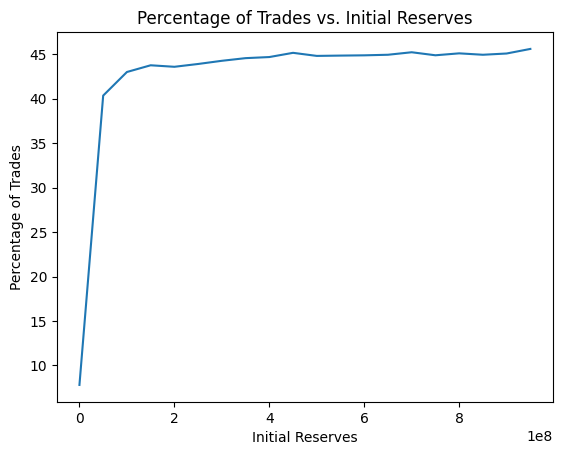

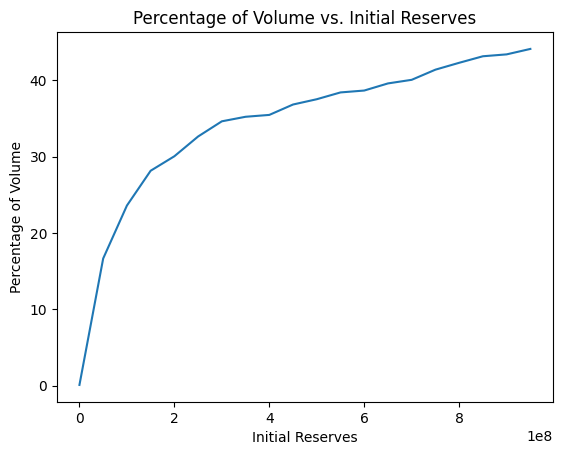

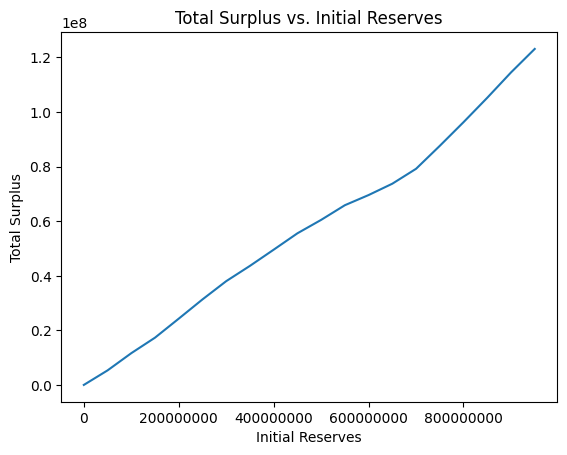

In [382]:
import matplotlib.pyplot as plt


token1 = "USDC"
token2 = "WETH"
fee_rate = 0.003 

# Study Starting reserves impact on key variables 

x = []
y1 = []
y2 = []
y3 = []


#range from 10mln to 1bn in 50mn increments for starting reserves. 
for token1_starting_reserves in range(100000, 1000100000, 50000000):
    x.append(token1_starting_reserves)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1.append(trades_executed_percentage)
    y2.append(executed_volume_percentage)
    y3.append(total_surplus)
    
    
df_results_USDC_WETH_reserves = pd.DataFrame({'starting reserves': x, '% of trades executed': y1, '% of volume executed': y2, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df_results_USDC_WETH_reserves)


# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


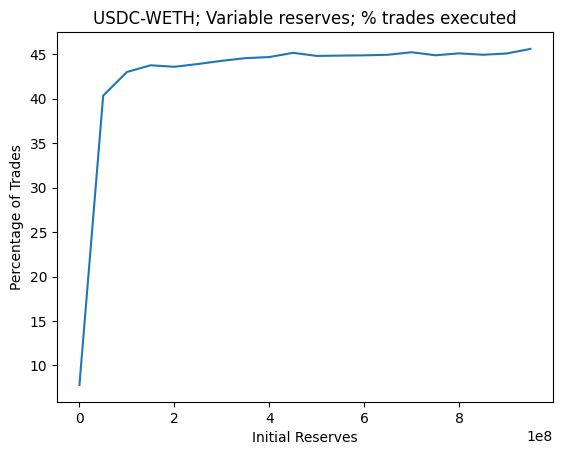

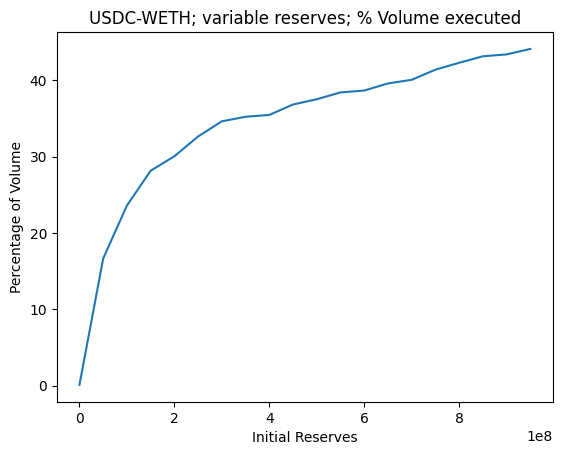

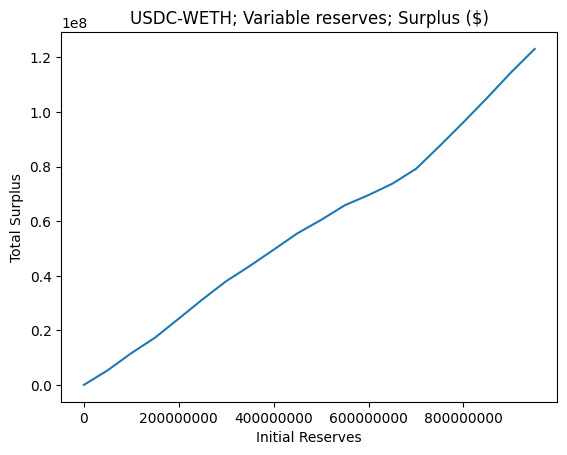

In [383]:

# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('USDC-WETH; Variable reserves; % trades executed')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('USDC-WETH; variable reserves; % Volume executed')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('USDC-WETH; Variable reserves; Surplus ($)')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


Note: 
Uni v2 USDC-WETH current reserves TVL : USD 86,620,798   
Uni v3 USDC-ETH current reserves TVL : 390,840,000 USD (Combining 0.3% pool + 0.05% pool )  

### b. Fee level 

In [384]:
import matplotlib.pyplot as plt

# starting reserves ~$100mln TVL
token1 = "USDC"
token2 = "WETH"
token1_starting_reserves = 50000000

# Study Starting reserves impact on key variables 

x_fee = []
y1_fee = []
y2_fee = []
y3_fee = []


#range from  0 - 6% increments of 0.1% for fees. 
# range method only accepts integers. 
for fee_rate_int in range(0, 60, 1):
    fee_rate = fee_rate_int/1000
    x_fee.append(fee_rate)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1_fee.append(trades_executed_percentage)
    y2_fee.append(executed_volume_percentage)
    y3_fee.append(total_surplus)
    
    
df_results_USDC_WETH_fee = pd.DataFrame({'starting reserves': x_fee, '% of trades executed': y1_fee, '% of volume executed': y2_fee, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df_results_USDC_WETH_fee)



# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y1_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y2_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y3_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


/tmp/ipykernel_14651/1687461370.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=True, inplace=True)


dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.0
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  8106
total_trades=  17073
percentage of trades executed =  47.478474784747846 %
  Volume:
total usd volume traded on feedlot=  296325142.69723034
total USD volume traded on COW 1537175254.2109973
volume percentage =  19.277251691729084 %
  Surplus:
total surplus 6050845.502755677
surplus percentage of volume 0.393634069126455 %
  LP metrics:
fees collected 0.0
ending reserves token1 40048118.30003584
ending reserves token2 25612.255992167604
dfs 17073 trades in sample
price column added
****** Feed

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.009
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  5398
total_trades=  17073
percentage of trades executed =  31.617173314590293 %
  Volume:
total usd volume traded on feedlot=  196676452.6433511
total USD volume traded on COW 1537175254.2109973
volume percentage =  12.794666847815044 %
  Surplus:
total surplus 4335807.344138736
surplus percentage of volume 0.2820633062014925 %
  LP metrics:
fees collected 1770088.0737901586
ending reserves token1 38962709.392622374
ending reserves token2 25210.019162305212
dfs 17073 trades in sample
price column

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.018
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  4106
total_trades=  17073
percentage of trades executed =  24.049669068119254 %
  Volume:
total usd volume traded on feedlot=  153281272.11218402
total USD volume traded on COW 1537175254.2109973
volume percentage =  9.97161980667327 %
  Surplus:
total surplus 3342425.7387103927
surplus percentage of volume 0.21743947084459123 %
  LP metrics:
fees collected 2759062.8980192957
ending reserves token1 38384160.13379825
ending reserves token2 24935.55397638806
dfs 17073 trades in sample
price column 

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.027
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  3311
total_trades=  17073
percentage of trades executed =  19.39319393193932 %
  Volume:
total usd volume traded on feedlot=  129621511.14367908
total USD volume traded on COW 1537175254.2109973
volume percentage =  8.432448466015108 %
  Surplus:
total surplus 2804768.1869753646
surplus percentage of volume 0.18246248625795103 %
  LP metrics:
fees collected 3499780.8008793285
ending reserves token1 37972617.34317526
ending reserves token2 24859.21056666675
dfs 17073 trades in sample
price column 

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.036
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  2827
total_trades=  17073
percentage of trades executed =  16.55830844022726 %
  Volume:
total usd volume traded on feedlot=  114592568.69092189
total USD volume traded on COW 1537175254.2109973
volume percentage =  7.454749767601488 %
  Surplus:
total surplus 2421140.8394349106
surplus percentage of volume 0.1575058427984931 %
  LP metrics:
fees collected 4125332.472873171
ending reserves token1 37743523.25871865
ending reserves token2 24751.355778362416
dfs 17073 trades in sample
price column a

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.045
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  2487
total_trades=  17073
percentage of trades executed =  14.566859954313829 %
  Volume:
total usd volume traded on feedlot=  100248098.36861488
total USD volume traded on COW 1537175254.2109973
volume percentage =  6.521578986780549 %
  Surplus:
total surplus 2118819.1765941987
surplus percentage of volume 0.1378384911408002 %
  LP metrics:
fees collected 4511164.426587663
ending reserves token1 37463044.02249356
ending reserves token2 24735.62394090008
dfs 17073 trades in sample
price column a

dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.054
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2022-03-01
ending date 2023-03-13
days -378 days, 16:53:00
  Trades:
trades executed =  2177
total_trades=  17073
percentage of trades executed =  12.751127511275111 %
  Volume:
total usd volume traded on feedlot=  88548899.27790007
total USD volume traded on COW 1537175254.2109973
volume percentage =  5.760494714921139 %
  Surplus:
total surplus 1894587.195150075
surplus percentage of volume 0.12325121614857966 %
  LP metrics:
fees collected 4781640.561006589
ending reserves token1 37241888.212157644
ending reserves token2 24723.74440072158
dfs 17073 trades in sample
price column a

ValueError: All arrays must be of the same length

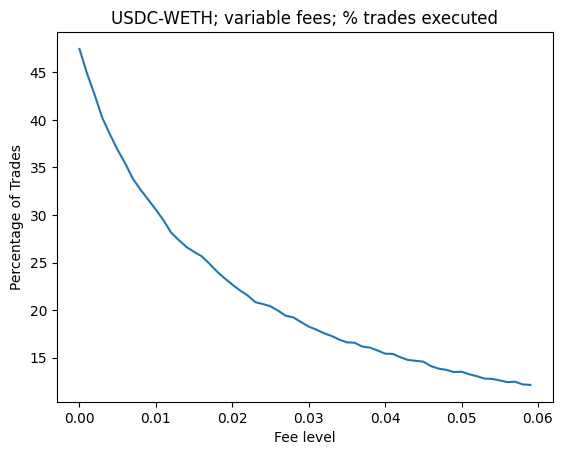

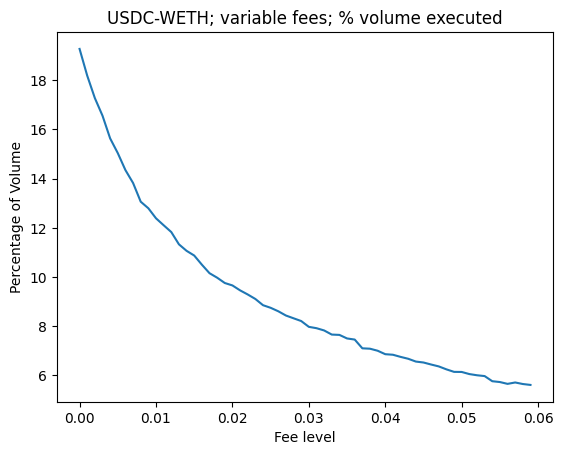

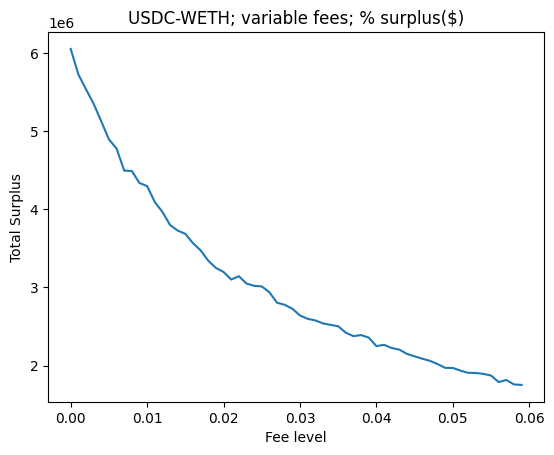

In [423]:

# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y1_fee)
ax.set_xlabel('Fee level')
ax.set_ylabel('Percentage of Trades')
ax.set_title('USDC-WETH; variable fees; % trades executed')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y2_fee)
ax.set_xlabel('Fee level')
ax.set_ylabel('Percentage of Volume')
ax.set_title('USDC-WETH; variable fees; % volume executed')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y3_fee)
ax.set_xlabel('Fee level')
ax.set_ylabel('Total Surplus')
ax.set_title('USDC-WETH; variable fees; % surplus($)')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


## 5. DAI-USDC – comparison with real UNIv2 returns 

Where studying a stable pool might not make too much sense on UNIv2 especially since there are more efficient pools on UNIv3 and on Curve for stable swaps, the study below still highlights the surplus numbers for a popular stable swap pair such as DAI-USDC. 

**5.1 get UNI returns**

In [ ]:
len(df)

In [ ]:
tokena = 'DAI'
tokenb = 'USDC'

In [ ]:
dai_usdc_df = df[((df.buy_token_symbol == tokena) & (df.sell_token_symbol == tokenb)) | ((df.sell_token_symbol == tokena) & (df.buy_token_symbol == tokenb))]

In [ ]:
dai_usdc_df = dai_usdc_df[dai_usdc_df['trades_sellAmountUsd'] > 250]
dai_usdc_df.sort_values(by='trades_timestamp', ascending=False, inplace=True)

In [ ]:
len(dai_usdc_df)

In [ ]:
# last trade
dai_usdc_df.iloc[0,1]

In [ ]:
dai_usdc_df.iloc[0,4]

In [ ]:
#Block number last trade = 16817883
#https://etherscan.io/tx/0xa3fc82535841fe7980e3a29aa8ab641f5c41effd6a21c20ea764f45c49ce9790

In [ ]:
# first trade
dai_usdc_df.iloc[-1,1]

In [ ]:
dai_usdc_df.iloc[-1,4]

In [ ]:
# Block number first trade  = 14300014
#https://etherscan.io/tx/0xe9d15d88a336fcd32cf6ac9fa6da6f726e8f3a953bd00e4b208181e74e74830c

In [ ]:
days = (datetime.utcfromtimestamp(dai_usdc_df.iloc[0,1]) - datetime.utcfromtimestamp(dai_usdc_df.iloc[-1,1]))
days

MANUAL WORK

UNIv2 data obtained from Etherscan: Reserves values + LP token supply

DAI-USDC pool address: 0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5   
DAI Address: 0x6b175474e89094c44da98b954eedeac495271d0f   
USDC Address: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48

https://etherscan.io/tokencheck-tool?t=0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc


In [ ]:
# Univ2 data at COW data last trade:
# UNIV2 USDC_WETH Token supply @ 16817883 = 11.510319181795390492  

# UNIV2 DAI Reserves = 12,977,224.344432413558677259
# UNIV2 USDC reserves = 12,982,573.818835 

In [ ]:
# Univ2 data at COW data first trade
# Block number =  14300014

# UNIV2 USDC_WETH Token supply @14300014 = 31.151563625852901815 

# UNIV2 DAI Reserves = 34,989,337.70919416559373272 DAI
# UNIV2 USDC reserves = 35,057,275.278217 USDC

In [ ]:
# LP value at period end. TVL/ LP token supply
LP_token_value_end_DU = (12977224.344432413558677259+12982573.818835) / 11.510319181795390492 
LP_token_value_end_DU

In [ ]:
LP_token_value_start_DU = (34989337.70919416559373272+35057275.278217 ) / 31.151563625852901815 
LP_token_value_start_DU

In [ ]:
# total return for period 
r_DU = LP_token_value_end_DU/LP_token_value_start_DU
r_DU

In [ ]:
# number of days: 
annual_DU = ((r_DU -1) * 365/376 )+1
annual_DU

In [ ]:
# get volume 

uni_ds = Streamer('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2')

In [ ]:
date_gt = dai_usdc_df.iloc[-1,1]
date_gt

In [ ]:
# date_gt = weth_usdc_df.iloc[-1,1] which is 1646097479 for this simulation. Change it it accordingly below to 
# obtain the right corresponding UNIv2 volume data. 

# query COW schema: trades
uni_pool_fp = uni_ds.queryDict.get('pairDayDatas')

# trades query path that gets token a -> token b trades. Query on query_size. 
uni_pool_qp = uni_pool_fp(
    first=2000,
    orderBy='date',
    orderDirection='desc',
    where = {
    'date_gt': 1646123362,
    'pairAddress': "0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5"
    }
)

# run query
uni_pool_df_DU = uni_ds.runQuery(uni_pool_qp)

In [ ]:
len(uni_pool_df_DU)

In [ ]:
# Total trade volume on UNI pool - USDC
total_uni_volume_DU = uni_pool_df_DU['pairDayDatas_dailyVolumeUSD'].sum()
total_uni_volume_DU

**5.2 get Feedlot returns**

In [ ]:
# run simulation with starting DAI reserves = 34989337.70919416559373272  as per the UNIv2 pool 

surplus_analysis('DAI','USDC', 34989337.70919416559373272 , 0.003)

In [ ]:
# ending value + the fees 
ending_value_DU = 34934782.00845561 + 34982434.43702582
ending_value_DU

In [ ]:
starting_value_DU = 34989337.70919417 + 34922219.62736098 
starting_value_DU

In [ ]:
r_feedlot_DU = ending_value_DU / starting_value_DU
r_feedlot_DU

**Results Summary**  
Time period: 377 days     
Total COW trade population: 331,802  
of which DAI-USDC : 6,358   
Total COW volume trades: 1,032,273,040  
Total UNI volume trades: 74,940,235  
trades % wouldve executed feedlot: 8.05%   
volume % would executed feedlot: 0.168%   
real UNI LP return over period: 0.30%   
Feedlot LP return over period: 0.00%  
Total surplus: 5,672